Deep Learning Assignment 2 part A
CS23M030

In [1]:
#importing all the necessary pytorch libraries
import torchvision
import torch
import torch.nn as nn
import seaborn as sns
sns.set()
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torch.optim as optim
#importing matplotlib for plotting
import matplotlib.pyplot as plt
import torchvision.models as models
import warnings
warnings.filterwarnings("ignore")
import torchvision.transforms as transforms
from torch.utils.data import random_split
import numpy as np






Installing wandb

In [2]:
#importing wandb and initializing with my key
!pip install wandb
import wandb
wandb.login(key='fbf80504ccef17f5f3b05723be7ea4caff805164')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Downloading dataset through wget and then extracting trainset and testset

In [3]:
#Downloading the dataset from the link given in assignment with wget library and loading data into trainset and testset

!pip install wget
import wget
#we provide the link of the file to be download to wget.download()
wget.download('https://storage.googleapis.com/wandb_datasets/nature_12K.zip')
#unzipping the innaturalist dataset
!unzip /content/nature_12K.zip
#funtion to load data into the trainset and testset

def data_loading():
    trainset= "/content/inaturalist_12K/train"
    testset = "/content/inaturalist_12K/val"
    return trainset,testset


Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

Q1.Building my CNN model

In [28]:
"""
This module defines a custom Convolutional Neural Network (CNN) model for image classification.
    Arguments
    num_filter: A list specifying the number of filters for each convolutional layer.
    kernel_dimensions: A list specifying the kernel size (filter size) for each convolutional layer.
    conv_activation: Activation function used in convolutional layers. Default is 'mish'.
    use_batch_normalization: Boolean indicating whether to use batch normalization. Default is True.
    dropout_probability: dropout_probability probability for dropout_probability layers. Default is 0.1.
    hidden_layer_size: Size of the fully connected layer. Default is 256.
    fully_connected_activation: Activation function used in the fully connected layer. Default is 'mish'.
    strideLength: Stride size for convolutional layers. Default is 2.
    img_len: Initial length of the input image. Default is 224.
    img_wid: Initial width of the input image. Default is 224.

"""

class Deep_Image_Classifier(nn.Module):
    def __init__(self, num_filter=[64,64,64,64,64], kernel_dimensions=[3,3,3,3,3], conv_activation='mish',use_batch_normalization=True,dropout_probability=0.1,hidden_layer_size=256,fully_connected_activation='mish' ,strideLength=2,img_len=224,img_wid=224):
        super(Deep_Image_Classifier,self).__init__()

        #Initializing all the class members
        #model hyperparameters
        self.wid=img_wid
        self.fully_connected_activation=fully_connected_activation # Activation function for fully connected layers
        self.density=1000
        self.len=img_len

        x=0
        while x<5:
             #this len will contain the final length of the image
             cal_len=(kernel_dimensions[x] - 1)
             self.len = (self.len - cal_len) // strideLength
             #this wid will contain the final width of the image
             cal_wid=(kernel_dimensions[x] - 1)
             self.wid = (self.wid - cal_wid) // strideLength
             x+=1


        #defining the dictionary for activation function
        act_func = {'gelu':nn.GELU(),'relu': nn.ReLU(),'silu':nn.SiLU(),'mish':nn.Mish()}
        self.conv_activation=conv_activation# Activation function for convolutional layers
        self.use_batch_normalization=use_batch_normalization # Whether to use batch normalization
        self.hidden_layer_size=hidden_layer_size #Size of Fully connected layer
        self.dropout_probability=dropout_probability # dropout_probability probability

        self.strideLength=strideLength #stride size for convolutional layers

        n4=num_filter[4]
        k4=kernel_dimensions[4]
        w_length=10
        n0=num_filter[0]
        k0=kernel_dimensions[0]
        self.layers = nn.ModuleList([
            #Defining the first layer
            nn.Conv2d(in_channels=3, out_channels=n0, kernel_size=k0),
            act_func[self.conv_activation],
            nn.BatchNorm2d(n0) if self.use_batch_normalization==True else nn.Identity() ,
            nn.MaxPool2d(kernel_size=2,stride=strideLength),

            #Defining the second layer
            nn.Conv2d(num_filter[0], num_filter[1], kernel_dimensions[1]),
            act_func[self.conv_activation],
            nn.BatchNorm2d(num_filter[1]) if self.use_batch_normalization==True else nn.Identity() ,
            nn.MaxPool2d(kernel_size=2,stride=strideLength),

            #Defining the third layer
            #All the convolutional layer contains a 2d conv layer followed by
            #A layer of activation function
            #Followed by a 2d maxpooling layer
            nn.Conv2d(num_filter[1], num_filter[2], kernel_dimensions[2]),
            act_func[self.conv_activation] ,
            nn.BatchNorm2d(num_filter[2]) if self.use_batch_normalization==True else nn.Identity() ,
            nn.MaxPool2d(kernel_size=2,stride=strideLength),

            #Defining the fourth layer
            nn.Conv2d(num_filter[2], num_filter[3], kernel_dimensions[3]),
            act_func[self.conv_activation] ,
            nn.BatchNorm2d(num_filter[3]) if self.use_batch_normalization==True else nn.Identity(),
            nn.MaxPool2d(kernel_size=2,stride=strideLength),


            #Defining the fifth layer
            nn.Conv2d(num_filter[3], n4, k4),
            act_func[self.conv_activation]  ,
            nn.BatchNorm2d(n4) if self.use_batch_normalization==True else nn.Identity(),
            nn.MaxPool2d(kernel_size=2,stride=strideLength),

            #Last fully connected layer
            nn.Flatten(),
            nn.Linear(int(n4*self.len*self.wid),hidden_layer_size),
            act_func[self.conv_activation],
            nn.Dropout(dropout_probability),
            nn.Linear(hidden_layer_size,w_length)

        ])
    def forwarpropagation(self,y):
        i=y
        return i

    #defining the forward propagation function for the model
    def forward(self, x):
        i=x
        for l in self.layers:
            x = l(x)
        return x

Checking the availability of GPU

In [22]:

torch.cuda.device_count()



check=torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
#calculating accuracy and loss
#for loss we are using cross entropy loss function
def calculateAccAndError(dataloader ,net,loss_fn ):
    epoch_loss_array = []
    #setting the total and correct to 0 initially
    tot, correct_label = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        def calcerr(self,y):
            i=y
            return i
        loss = loss_fn(outputs, labels)
        epoch_loss_array.append(loss.item())
        #we are using the index of the max value and not using the maximum value itself that's why we have used '_'
        _, pred = torch.max(outputs.data, 1)
        def calprediction(self,prediction):
            z=predictions
            z=do_pred()
            return z
        tot += labels.size(0)
        correct_label += (pred == labels).sum().item()

    return 100 * correct_label / tot,sum(epoch_loss_array)/len(epoch_loss_array)

In [24]:
#defining my main function
def main(num_filter=[64,64,64,64,64], kernel_dimensions=[3,3,3,3,3], conv_activation='mish',enable_data_aug=True,use_batch_normalization=True,dropout_probability=0.1,hidden_layer_size=256,fully_connected_activation='mish' ,strideLength=2,maximum_training_epochs=10):
    #loading the data into the trainset and testset
    trainset,testset=data_loading()
    p=0.5
    rotate=10
    resize=224
    mean1=0.485
    mean2=0.456
    mean3=0.406
    variance1=0.229
    variance2=0.224
    variance3=0.225
    scale1=0.02
    scale2=0.33
    ratio1=0.3
    ratio2=3.3
    #applying my transformations on the train data
    transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p),
    transforms.RandomRotation(rotate),
    transforms.Resize((resize,resize)),
    transforms.ToTensor(),
    transforms.Normalize((mean1, mean2, mean3), (variance1, variance2, variance3)),
    transforms.CenterCrop((resize,resize)),
    transforms.RandomErasing(p, scale=(scale1, scale2), ratio=(ratio1, ratio2)),
    ])

    #applying my tranformations on the test data
    transform = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize((mean1, mean2, mean3), (variance1, variance2, variance3))
    ])


    def ret_train(trainset,transform_t):
        return datasets.ImageFolder(trainset,transform_t)
    #Checking for the data augmentation
    def ret_test(testset,test_transform):
        return datasets.ImageFolder(testset,test_transform)
    check=enable_data_aug
    if not check:
        trainset = ret_train(trainset,transform)
        testset = ret_test(testset,transform)
    elif check:
        trainset = ret_train(trainset,transform_train)
        testset = ret_test(testset,transform)

    #splitting the training data into trainset and the validation set
    calcu=len(trainset)
    calcu=int(np.floor(0.2 * calcu))
    n_validation = calcu
    def do_split(trainset,n_training ,n_validation):
        return random_split(trainset,[n_training ,n_validation])
    n_training  = len(trainset) - n_validation
    #splitting randomly into the given ratio
    trainset,evalset=do_split(trainset,n_training ,n_validation)
    def make_split(testset,a):
        return random_split(testset,[len(testset),a])
    testset,testset2=make_split(testset,0)

    #batch size of 32 is giving good performance, so we are taking all the samples in the batch of 32
    batch_size = 32
    #below is the utility function for testing
    def u2(x):
        return x>0

    shuffle=True
    trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle)
    #shuffing the data so that we always get the random set

    evalloader = torch.utils.data.DataLoader(evalset, batch_size, shuffle)
    testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle)

    #creating an object of the Deep_Image_Classifier class
    net = Deep_Image_Classifier().to(device)
    lr=1e-4
    loss_fn = nn.CrossEntropyLoss()
    paramet=net.parameters()
    def funct_print(epoch,i):
        print("epoch  ",epoch,"batch  ",i)
    opt = optim.Adamax(paramet,lr)

    epoch=0
    while epoch < (maximum_training_epochs):
      #list created for storing loss in each epoch
        epoch_loss_array = []
        z=0
        for i, data in enumerate(trainloader, z):
          #printing for every 50th item
            if i%50==0:
                funct_print(epoch,i)

            #extracting the inputs and labels from the data
            inputs_data, labels_data = data
            def getinputLabels(self,labels):
                return labels
            inputs_data, labels_data = inputs_data.to(device), labels_data.to(device)

            #applying optimizer to it
            def get_epoch_out(inputs_data):
                return net(inputs_data)
            opt.zero_grad()
            def cal_loss(epoch_outputs,labels_data):
                return loss_fn(epoch_outputs, labels_data)

            #passing the input to the model for classication
            def update():
                epoch_outputs = get_epoch_out(inputs_data)

                loss_calculate = cal_loss(epoch_outputs, labels_data)
                #backward propagation
                loss_calculate.backward()
                opt.step()
                epoch_loss_array.append(loss_calculate.item())
            update()

        #calculating the train loss
        loss_train=sum(epoch_loss_array)/len(epoch_loss_array)
        train_acc,evaluating_loss=calculateAccAndError(trainloader,net,loss_fn)
        def updateparas(self,parameters):
            return parameters
        eval_acc,loss_eval=calculateAccAndError(evalloader,net,loss_fn)
        #printing all the accuracy and loss
        print(f'train loss:- {loss_train} train acc:- {train_acc} val loss:- {loss_eval} val acc:- {eval_acc} ')
        wandb.log({'train loss':loss_train,'train acc':train_acc, 'val loss':loss_eval,'val acc':eval_acc})
        epoch+=1



In [29]:
#Building sweep for trying all the hyperparameters and finding the best hyperparameters
#checking for sweep

def initiate_sweep():
  print("checking whether sweep running or not")

#defining the sweep configuration
sweep_config={
  "name" : "sweep1",
  "method": "bayes",
  "metric": {
      "name": "val acc",
      "goal": "maximize"
    },
  "parameters": {
        "fully_connected_activation":{
            "values":['mish','relu','silu','gelu']
        },

        "strideLength":{
            "values":[2,3,5]
        },
        "enable_data_aug":{
            "values":[True,False]
        },

        "num_filter":{
            "values":[[32,32,32,32,32],[64,64,64,64,64],[512,256,128,64,32],[32,64,128,256,512]]
        },

        "conv_activation":{
            "values":['mish','relu','silu','gelu']
        },

        "kernel_dimensions":{
            "values":[[11,9,7,5,3],[5,5,5,5,5],[3,3,3,3,3]]
        },



        "use_batch_normalization": {
            "values": [False,True]
        },

        "maximum_training_epochs": {
            "values": [5,8,10]
        },



        "dropout_probability":{
            "values":[0.3,0.2,0.1]
        },
        "hidden_layer_size":{
            "values":[128,256,512]
        }

    }
}

In [30]:
#defining my train function which is used for initializing parameters selected in the sweep and then calling the main function with the selected parameters
def train():
    wandb.init()
    config=wandb.config
    #taking various  parameters from the sweep

    wandb.run.name = 'maximum_training_epochs' + str(config.maximum_training_epochs) +'_conv_activation_' + config.conv_activation + '_enable_data_aug_' + str(config.enable_data_aug) + '_use_batch_normalization_' + str(config.use_batch_normalization) +'_fully_connected_activation_' + str(config.fully_connected_activation)  + '_dropout_probability_' + str(config.dropout_probability) + '_hidden_layer_size_' + str(config.hidden_layer_size)+'_strideLength_'+str(config.strideLength)

    #calling the main function with the selected input
    main(config.num_filter, config.kernel_dimensions, config.conv_activation,config.enable_data_aug,config.use_batch_normalization,config.dropout_probability,config.hidden_layer_size,config.fully_connected_activation ,config.strideLength,config.maximum_training_epochs)
    wandb.finish()

In [31]:
sweep_id=wandb.sweep(sweep=sweep_config,project="ASSIGN_2_DL_testing")
wandb.agent(sweep_id,train,count=1)

Create sweep with ID: uynvmz3m
Sweep URL: https://wandb.ai/cs23m030/ASSIGN_2_DL_testing/sweeps/uynvmz3m


wandb: Agent Starting Run: u9iyirqz with config:
wandb: 	conv_activation: mish
wandb: 	dropout_probability: 0.1
wandb: 	enable_data_aug: False
wandb: 	fully_connected_activation: mish
wandb: 	hidden_layer_size: 256
wandb: 	kernel_dimensions: [3, 3, 3, 3, 3]
wandb: 	maximum_training_epochs: 2
wandb: 	num_filter: [512, 256, 128, 64, 32]
wandb: 	strideLength: 3
wandb: 	use_batch_normalization: True


epoch   0 batch   0
epoch   0 batch   50
epoch   0 batch   100
epoch   0 batch   150
epoch   0 batch   200
train loss:- 2.0851607499122617 train acc:- 33.175 val loss:- 1.9624741474787395 val acc:- 32.566283141570786 
epoch   1 batch   0
epoch   1 batch   50
epoch   1 batch   100
epoch   1 batch   150
epoch   1 batch   200
train loss:- 1.893517451286316 train acc:- 37.325 val loss:- 1.8995305602512662 val acc:- 33.26663331665833 


In [32]:
wandb.finish()

In [33]:
#for Question 4
#selecting the best model after running the sweep

net = Deep_Image_Classifier().to(device)
loss_fn = nn.CrossEntropyLoss()
batch_size = 32
params=net.parameters()
opt = optim.Adamax(params,lr=1e-4)

In [34]:
#loading the train and test data
trainset,testset=data_loading()
shuffle=True
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle)

#appying my tranformations to the testdata
resize=224
mean1=0.485
mean2=0.456
mean3=0.406
variance1=0.229
variance2=0.224
variance3=0.225
transform_on_test = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize((mean1, mean2, mean3), (variance1, variance2, variance3))
    ])
testset = datasets.ImageFolder(testset,transform_on_test)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle)

In [44]:
#defining the main function for question 4
def main(num_filter=[64,64,64,64,64], kernel_dimensions=[3,3,3,3,3], conv_activation='mish',enable_data_aug=True,use_batch_normalization=True,dropout_probability=0.1,hidden_layer_size=256,fully_connected_activation='mish' ,strideLength=2,maximum_training_epochs=10):

    trainset,testset=data_loading()
    p=0.5
    resize=224
    mean1=0.485
    mean2=0.456
    mean3=0.406
    var1=0.229
    var2=0.224
    var3=0.225
    s1=0.02
    s2=0.33
    r1=0.3
    r2=3.3
    #Applying my transformation on the trainset
    #defining transformations for data augmentation
    transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p),
    transforms.RandomRotation(10),
    transforms.Resize((resize,resize)),
    transforms.ToTensor(),
    transforms.Normalize((mean1, mean2, mean3), (var1, var2, var3)),
    transforms.CenterCrop((224,224)),
    transforms.RandomErasing(p, scale=(s1, s2), ratio=(r1, r2)),
    ])


    variance1=0.229
    variance2=0.224
    variance3=0.225
    transform = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize((mean1, mean2, mean3), (variance1, variance2, variance3))
    ])


    #checking for data augmentation
    def ret_trainset(trainset,transform_train):
        return datasets.ImageFolder(trainset,transform_train)

    def ret_testset(testset,transform_test):
        return datasets.ImageFolder(testset,transform_test)
    check=enable_data_aug
    if not check:
        trainset = ret_trainset(trainset,transform)
        testset =  ret_testset(testset,transform)
    elif check:
        trainset = ret_trainset(trainset,transform_train)
        testset = ret_testset(testset,transform)

    calcu=0.2 * len(trainset)
    vali=np.floor(calcu)
    n_validation = int(vali)
    length_train_set=len(trainset)
    n_training  = length_train_set - n_validation
    trainset,evalset=random_split(trainset,[n_training ,n_validation])
    testset,testset2=random_split(testset,[len(testset),0])

    #trainloader , evalloader are used to load data after applying tranformations on it
    batch_size = 32
    shuffle=True
    trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle)
    evalloader = torch.utils.data.DataLoader(evalset, batch_size, shuffle)
    testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle)


    #utility function for checking
    def u1(x):
      return x


    def input_Label(data):
        inputs,labels=data
        return inputs,labels
    #now starting the epoch


    epoch=0
    while epoch < (maximum_training_epochs):
        epoch_loss_array = []
        for i, data in enumerate(trainloader, 0):
            #extracting the inputs and labels from the data
            inputs, labels = input_Label(data)
            inputs, labels = inputs.to(device), labels.to(device)
            #applying the optimizer
            def ret_net(inputs):
                return net(inputs)
            opt.zero_grad()

            epoch_outputs = ret_net(inputs)
            #calculating the loss through cross entropy loss function
            def cal_loss(epoch_outputs,labels):
              return loss_fn(epoch_outputs,labels)
            loss_calculate = cal_loss(epoch_outputs, labels)
            #backward propagation

            loss_calculate.backward()
            #Performing optimizer step
            opt.step()

            epoch_loss_array.append(loss_calculate.item())
        #calculating the various accuracy and loss
        summation=sum(epoch_loss_array)
        length=len(epoch_loss_array)

        loss_train = summation/length
        train_acc,_ = calculateAccAndError(trainloader,net,loss_fn)
        eval_acc,loss_eval=calculateAccAndError(evalloader,net,loss_fn)
        print(f' epoch:- {epoch } train loss:- {loss_train} train acc:- {train_acc} val loss:- {loss_eval} val acc:- {eval_acc} ')
        epoch+=1
    #funtion for calculating loss using mean square error
    def loss_calculation_using_me(t,p):
        squared_loss = torch.mean((t - p)**2)


    #Now testing the model on test accuracy
    print("finally testing my model on the test accuracy")
    test_acc,test_loss=calculateAccAndError(testloader,net,loss_fn)
    print("Deep_Image_Classifier test loss",test_loss,"Deep_Image_Classifier test acc",test_acc)



In [45]:
#calling the main function with the best parameters
filter_n=[512,256,128,64,32]
kernel_d=[3,3,3,3,3]
e_var=5
main(filter_n,kernel_d,'gelu',False,True,0.1,256,'mish',2,e_var)


 epoch:- 0 train loss:- 2.0889705123901368 train acc:- 32.7125 val loss:- 2.0125411767808217 val acc:- 28.264132066033017 
 epoch:- 1 train loss:- 1.9175038352012634 train acc:- 36.625 val loss:- 1.9361513815228901 val acc:- 32.16608304152076 
 epoch:- 2 train loss:- 1.8234856338500978 train acc:- 40.4375 val loss:- 1.9024007661002023 val acc:- 32.21610805402701 
 epoch:- 3 train loss:- 1.7383709859848022 train acc:- 43.6125 val loss:- 1.8807425006987557 val acc:- 33.616808404202104 
 epoch:- 4 train loss:- 1.6556084976196288 train acc:- 46.9625 val loss:- 1.87224485003759 val acc:- 32.51625812906453 
finally testing my model on the test accuracy
Deep_Image_Classifier test loss 1.8457092954998924 Deep_Image_Classifier test acc 37.3


In [47]:
#this module is for printing the image with the true label and the predicted label by my model
#this module is printing 10*3=30 images

def predict_labels(dataloader=testloader, model=net):
    # Now evaluating
    wandb.init()
    model.eval()
    arr_of_plot = []

    def correction_std():
        return np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)

    # Initialize figure for making images
    fig, axes_arr = plt.subplots(10, 3, figsize=(10, 30))

    # Iterate over batches in dataloader


    def correction_mean():
        return np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    def calc_image(image,std_correction,mean_correction):
        return np.multiply(image.cpu(), std_correction) + mean_correction


    for i, batch in enumerate(dataloader):
        # Get batch of images and labels
        def get_pred(preds,j):
            return preds[j]

        if i>0:
          break
        def get_images(images,j):
            return images[j]
        images, labels = batch
        def get_label(labels,j):
            return labels[j]
        images,labels=images.to(device),labels.to(device)
        def cal_row_index(i,j):
          return (i * 3 + j) // 3
        # Make predictions with model
        with torch.no_grad():
            outputs = model(images)
            #here we are taking only the index and ignoring the image
            _, preds = torch.max(outputs, 1)

        # Plot images with actual and predicted labels as titles
        def cal_col_index(i,j):
          return (i * 3 + j) % 3
        j=0
        while j<(images.size()[0]):
            pred = get_pred(preds,j)
            image = get_images(images,j)
            label = get_label(labels,j)

            mylabel=classes[label.item()]
            mypred=classes[pred.item()]
            std_correction = correction_std()
            mean_correction = correction_mean()
            image = calc_image(image,std_correction,mean_correction)

            # Calculate the row and column indices of the current subplot
            row_index = cal_row_index(i,j)
            col_index = cal_col_index(i,j)
            total_value=row_index*3+col_index
            if total_value>29:
                break

            arr_of_plot.append(wandb.Image(image,caption= 'True='+ mylabel +', Predicted='+mypred))
            axes_arr[cal_row_index(i,j), cal_col_index(i,j)].imshow(torchvision.utils.make_grid(image, nrow=1).permute(1, 2, 0))
            axes_arr[row_index, col_index].set_title('Actual: {} \nPredicted: {}'.format(mylabel, mypred))
            axes_arr[row_index, col_index].axis('off')

            # Check if we have displayed all 30 images
            x_val=(i+1)*30 + j
            if x_val == len(dataloader.dataset):
                break
            j+=1
        # Check if we have displayed all 30 images
        def ret_check(y_val,length):
            if y_val==length:
                return True
            else:
                return False

        y_val=(i+1)*30
        length_a=len(dataloader.dataset)
        if ret_check(y_val,length_a):
            break

    plt.tight_layout()
    plt.show()
    #now logging into wandb
    wandb.log({"images":arr_of_plot})


In [48]:
#defining the various class labels for prediction
classes=('Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia')

Create sweep with ID: z4xqmruk
Sweep URL: https://wandb.ai/cs23m030/ASSIGN_2_DL_testing/sweeps/z4xqmruk


wandb: Agent Starting Run: b7b44rsy with config:
wandb: 	conv_activation: gelu
wandb: 	dropout_probability: 0.2
wandb: 	enable_data_aug: True
wandb: 	fully_connected_activation: relu
wandb: 	hidden_layer_size: 512
wandb: 	kernel_dimensions: [3, 3, 3, 3, 3]
wandb: 	maximum_training_epochs: 2
wandb: 	num_filter: [32, 64, 128, 256, 512]
wandb: 	strideLength: 3
wandb: 	use_batch_normalization: True


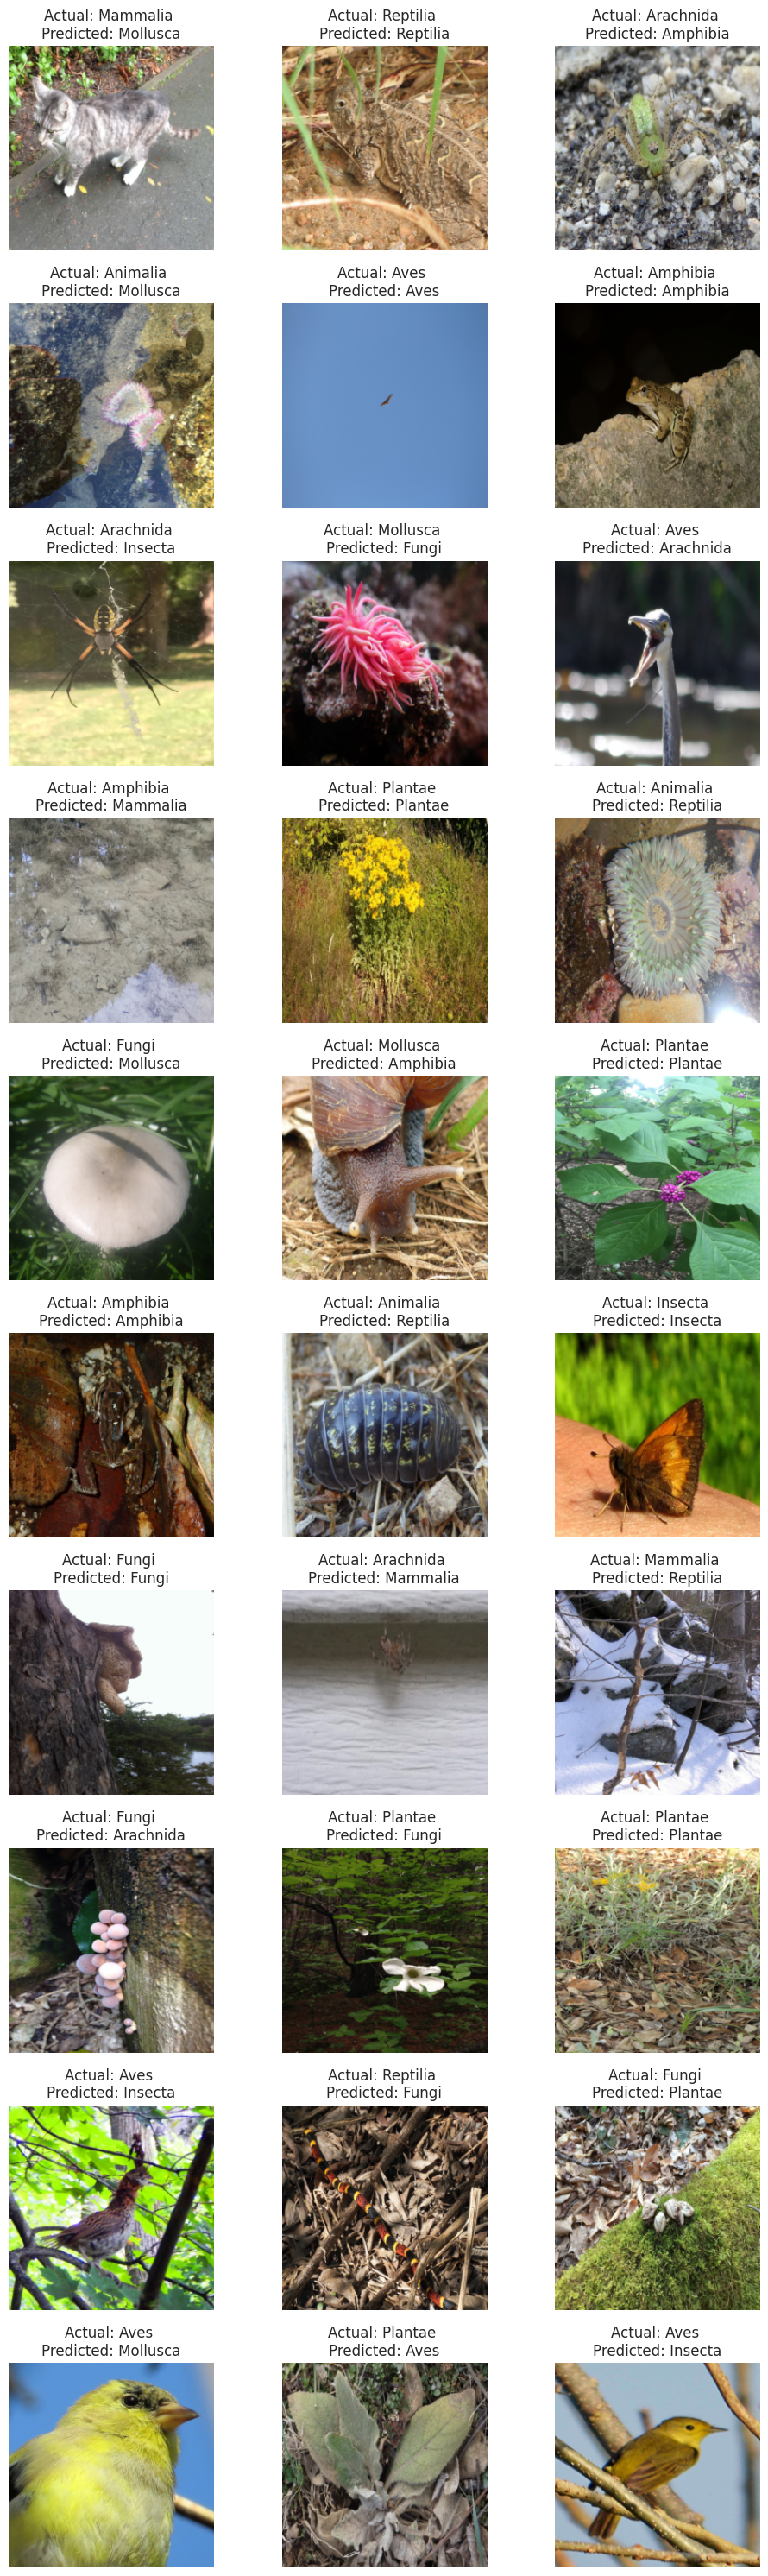

In [51]:
#running the sweep one time for the test data
def get_sweepid():
    return wandb.sweep(sweep=sweep_config,project="ASSIGN_2_DL_testing")
sweep_id=get_sweepid()
wandb.agent(sweep_id,predict_labels,count=1)


In [ ]:
wandb.finish()